### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
from sklearn.decomposition import PCA, KernelPCA

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from pandas.plotting import parallel_coordinates


In [2]:
class LogTransformer(TransformerMixin, BaseEstimator):
    """
    A transformer that applies natural logarithm transformation to the input data.

    Attributes:
    -----------
    seed : float
        The seed value used for adding to the input data before logarithmic transformation.
    """

    def __init__(self):
        """
        Initialize the LogTransformer.

        Parameters:
        -----------
        seed : float, optional, default: 1e-5
            A small value added to the input data before applying logarithm to avoid taking the logarithm of zero or negative values.
        """
        self.seed = 1e-5

        
    def fit(self, X):
        """
        Fit the LogTransformer to the data. This method does nothing as this transformer does not learn anything from the data.

        Parameters:
        -----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input data.

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        return self
    
        
    def transform(self, X, y=None):
        """
        Transform the input data by applying natural logarithm.

        Parameters:
        -----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input data.

        Returns:
        --------
        X_transformed : array-like or sparse matrix, shape (n_samples, n_features)
            The transformed data after applying natural logarithm to each element.
        """
        return np.log(X + self.seed)

In [3]:
data = pd.read_csv('data/preprocessed_data_ghea.csv').drop(columns=['Unnamed: 0', 'Segment', 'sSSE', 'lSSE'])
data

,Sub_Zone,Longitude,Latitude,Sed_Thick,Age,Dip,Vel,Rough,Max_mag
0,Alaska_Aleutian,162.496502,55.224997,1104.879474,NaN,NaN,75.043071,49.217635,7.80
1,Alaska_Aleutian,162.889506,55.224944,834.474965,100.827519,NaN,74.963034,27.201008,7.80
2,Alaska_Aleutian,163.282509,55.224786,694.147016,100.709354,NaN,74.820092,55.719616,7.80
3,Alaska_Aleutian,163.675510,55.224645,728.588568,100.411265,NaN,74.742569,39.590255,7.80
4,Alaska_Aleutian,164.063394,55.208113,804.954842,99.209300,NaN,74.674081,28.093870,7.30
...,...,...,...,...,...,...,...,...,...
1535,Vanuatu,171.343299,-23.104977,372.068752,24.788005,48.583207,69.300072,11.596893,7.70
1536,Vanuatu,171.584212,-23.134444,349.441230,24.370304,47.837679,69.147810,9.177595,7.70
1537,Vanuatu,171.827463,-23.146327,289.861146,24.466122,45.633511,68.990344,11.492597,7.70
1538,Vanuatu,172.067833,-23.127165,261.287949,24.106751,45.789668,68.833309,7.392793,7.70


### Pipeline parameters

In [4]:
scaler = StandardScaler()

# pca = KernelPCA(kernel='cosine', random_state=42)
pca = PCA(random_state=42) # for linear PCA 

pca = KernelPCA(kernel='rbf', random_state=42, gamma = .005)

# add or remove features 
to_log = ['Sed_Thick', 'Dip', 'Rough'] 
no_log = ['Vel'] 

### Define pipeline

In [5]:
log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                        ('Log Transform', LogTransformer()),
                        ('Scaler', scaler)])

no_log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                            ('Scaler', scaler)])

pca_preproc = ColumnTransformer([
    ('Log. Preprocessor', log_preproc, to_log),
    ('Preprocessor', no_log_preproc, no_log)],
    remainder='drop')

pca_pipe = Pipeline([
    ('preprocessing', pca_preproc),
    ('PCA', pca)])

pca_pipe.fit(data)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Log. Preprocessor',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('Log '
                                                                   'Transform',
                                                                   LogTransformer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['Sed_Thick', 'Dip',
                                                   'Rough']),
                                                 ('Preprocessor',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['Vel'])])),
                ('PCA', KernelPCA(gamma=0.005, kernel='rbf', random_state=42))])

### Project data

In [6]:
data_proj = pca_pipe.transform(data)
pc_columns = [f'PC{i}' for i in range(1,data_proj.shape[1]+1)]
data_proj = pd.DataFrame(data_proj, columns = pc_columns)
data_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147
0,-0.003120,0.235741,0.042390,-0.063884,-0.004614,0.023378,0.023728,0.024872,0.000501,-0.002990,...,4.275923e-07,-2.610977e-08,2.666570e-07,2.571398e-07,-1.886865e-07,4.808544e-07,-1.269864e-07,-1.771241e-08,4.175490e-09,-4.392170e-07
1,-0.009028,0.164930,0.026009,-0.064074,-0.012559,0.012148,0.010835,0.007800,0.001332,-0.003448,...,-6.822347e-08,6.934930e-08,6.032354e-08,1.548793e-07,-2.208390e-07,2.344182e-07,2.162824e-08,1.490148e-07,3.191651e-07,-1.352355e-07
2,0.028157,0.219812,0.062034,-0.025868,-0.009569,0.013945,0.016741,0.023150,-0.001917,-0.003116,...,2.260147e-07,-9.832604e-09,-5.674804e-08,2.287578e-07,-1.853168e-07,4.647598e-08,6.462687e-08,1.654071e-07,-6.781386e-08,9.216592e-09
3,0.012492,0.191496,0.046702,-0.041209,-0.012282,0.012667,0.012778,0.014756,-0.000727,-0.003532,...,1.595802e-07,-3.507844e-08,-6.338439e-08,2.138088e-07,-1.867256e-07,1.324994e-07,4.385720e-08,1.153439e-07,1.642010e-07,-3.549985e-08
4,-0.006362,0.165596,0.029438,-0.060321,-0.012885,0.011884,0.010613,0.008065,0.000936,-0.003571,...,-3.593232e-08,4.554589e-08,3.961179e-08,1.518903e-07,-2.157221e-07,2.150057e-07,2.424827e-08,1.308172e-07,3.040943e-07,-1.137480e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,0.070924,0.011242,0.079151,-0.123848,0.006810,0.008923,-0.010958,-0.002643,0.001310,-0.001422,...,1.911530e-07,5.561151e-08,-3.557778e-08,2.624543e-07,1.423864e-07,-3.122295e-08,1.640910e-08,-1.556460e-07,1.055560e-08,1.773283e-07
1536,0.064077,-0.014749,0.070340,-0.124730,0.006620,0.008571,-0.010857,-0.003816,0.001516,0.002783,...,3.517681e-07,7.185167e-08,-1.221148e-07,2.829852e-07,2.185320e-07,6.185746e-08,-4.894355e-08,-2.600688e-07,5.680386e-08,2.807674e-07
1537,0.078329,-0.003883,0.083160,-0.097458,0.003583,0.007376,-0.012389,-0.004038,0.002795,-0.000688,...,-9.219247e-08,1.264264e-07,-7.379651e-08,1.308695e-07,2.338938e-07,4.938875e-08,1.735571e-07,-1.276043e-07,-8.979168e-08,8.887537e-08
1538,0.068153,-0.052703,0.067562,-0.103968,0.005490,0.008420,-0.011722,-0.004219,0.002920,0.007158,...,1.995771e-07,1.563756e-07,-1.424842e-07,1.082778e-07,3.282922e-07,2.293009e-07,6.459049e-08,-3.681030e-07,5.915444e-08,2.266290e-07


### Calculate and plot explained variance

In [7]:
X_proj_pca = data_proj[pc_columns]
explained_variance_ratio = (X_proj_pca.std()**2 / ((X_proj_pca.std()**2).sum())).values
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

#### For cosine kernel

In [8]:
upper_pc_bound = len(cumulative_explained_variance_ratio)

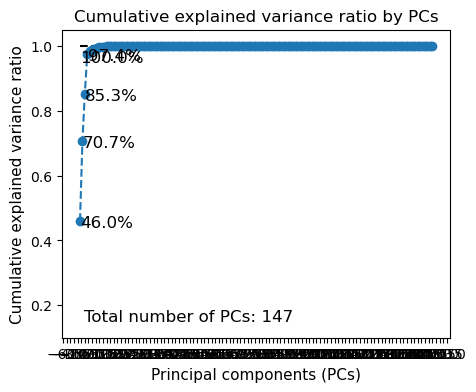

In [9]:
fig,ax = plt.subplots(1,1, figsize = (5,4))
fontsize = 12
ax.plot(np.arange(1,upper_pc_bound+1),np.ones(upper_pc_bound) * cumulative_explained_variance_ratio[upper_pc_bound-1], \
        '--', c = 'k')
ax.annotate(f'{np.round(100*cumulative_explained_variance_ratio[upper_pc_bound-1],1)}%', (1,0.95), fontsize = fontsize)

ax.plot(np.arange(1,upper_pc_bound+1),cumulative_explained_variance_ratio, '--o')

for i in range(4):
    text_location = (i+1.2, cumulative_explained_variance_ratio[i]-.02)
    ax.annotate(f'{np.round(100*cumulative_explained_variance_ratio[i],1)}%', text_location, fontsize = fontsize)
    
ax.set_title('Cumulative explained variance ratio by PCs', fontsize  = fontsize)
ax.annotate(f'Total number of PCs: {data_proj.shape[1]}', (2.5,0.15), fontsize = fontsize)
ax.set_xlabel('Principal components (PCs)', fontsize  = fontsize-1)
ax.set_ylabel('Cumulative explained variance ratio', fontsize  = fontsize-1)
ax.set_ylim([0.1, 1.05])
ax.xaxis.set_major_locator(plt.MaxNLocator(data_proj.shape[1]))

#### For RBF kernel

In [10]:
upper_pc_bound = 50

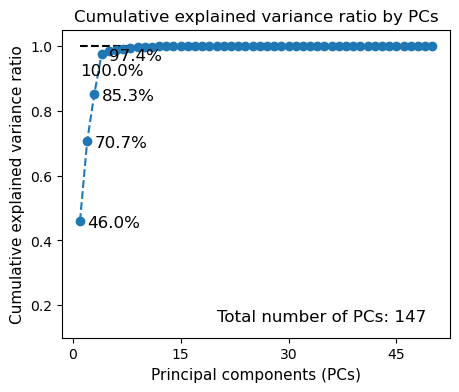

In [11]:
fig,ax = plt.subplots(1,1, figsize = (5,4))
fontsize = 12
ax.plot(np.arange(1,upper_pc_bound+1),np.ones(upper_pc_bound) * cumulative_explained_variance_ratio[upper_pc_bound-1], \
        '--', c = 'k')
ax.annotate(f'{np.round(100*cumulative_explained_variance_ratio[upper_pc_bound-1],1)}%', (1, 0.91), fontsize = fontsize)

ax.plot(np.arange(1,upper_pc_bound+1),cumulative_explained_variance_ratio[:upper_pc_bound], '--o')

for i in range(4):
    text_location = (i+2, cumulative_explained_variance_ratio[i]-.02)
    ax.annotate(f'{np.round(100*cumulative_explained_variance_ratio[i],1)}%', text_location, fontsize = fontsize)
    
ax.set_title('Cumulative explained variance ratio by PCs', fontsize  = fontsize)
ax.annotate(f'Total number of PCs: {data_proj.shape[1]}', (20,0.15), fontsize = fontsize)
ax.set_xlabel('Principal components (PCs)', fontsize  = fontsize-1)
ax.set_ylabel('Cumulative explained variance ratio', fontsize  = fontsize-1)
ax.set_ylim([0.1, 1.05])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

### Iterating over gamma

In [12]:
linear_data = pd.read_csv('linear_data.csv').drop(columns = ['Unnamed: 0'])

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
pca_clusters = kmeans.fit_predict(linear_data[['PC1', 'PC2']])

In [14]:
gamma_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

variances = []
aris = []

for gamma in gamma_values:
    scaler = StandardScaler()
    pca = KernelPCA(kernel='rbf', random_state=42, gamma = gamma)

    to_log = ['Sed_Thick', 'Dip', 'Rough'] 
    no_log = ['Vel'] 

    log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                            ('Log Transform', LogTransformer()),
                            ('Scaler', scaler)])

    no_log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                                ('Scaler', scaler)])

    pca_preproc = ColumnTransformer([
        ('Log. Preprocessor', log_preproc, to_log),
        ('Preprocessor', no_log_preproc, no_log)],
        remainder='drop')

    pca_pipe = Pipeline([
        ('preprocessing', pca_preproc),
        ('PCA', pca)])

    pca_pipe.fit(data)

    data_proj = pca_pipe.transform(data)
    pc_columns = [f'PC{i}' for i in range(1,data_proj.shape[1]+1)]
    data_proj = pd.DataFrame(data_proj, columns = pc_columns)

    X_proj_pca = data_proj[pc_columns]
    explained_variance_ratio = (X_proj_pca.std()**2 / ((X_proj_pca.std()**2).sum())).values
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    variances.append(cumulative_explained_variance_ratio[1])
    
    kpca_clusters = kmeans.fit_predict(data_proj[['PC1', 'PC2']])
    ari = adjusted_rand_score(pca_clusters, kpca_clusters)
    aris.append(ari)

    print(gamma, cumulative_explained_variance_ratio[1], ari)

0.001 0.7254214881694669 0.9956644743087945
0.005 0.7073512380520175 0.9274590346453604
0.01 0.6861070561082778 0.9324180600580262
0.05 0.5565617338718464 0.8049277072430386
0.1 0.4559926290953633 0.668731207261341
0.2 0.34223542632583054 0.636280626416022
0.3 0.2769246434842325 0.5535968462466085
0.4 0.23360391582558337 0.5148410992424859
0.5 0.202569006994189 0.42907774106308216
0.6 0.17918934280508425 0.3618310098822693
0.7 0.16093518156579156 0.3160310322197623
0.8 0.14630082702156447 0.27308908164980017
0.9 0.13432838469695302 0.23362811838345032
1 0.12436928237711609 0.041623198850575215


Text(0.5, 0, 'gamma')

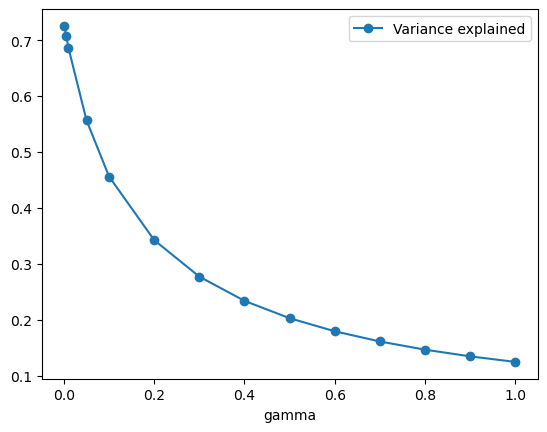

In [15]:
# plt.plot(gamma_values, aris, 'o-', label = 'ARI')
plt.plot(gamma_values, variances, 'o-', label = 'Variance explained')
plt.legend()
plt.xlabel('gamma')

### Parallel coordinates plots for features

In [16]:
to_log = ['Sed_Thick', 'Dip', 'Rough'] 
no_log = ['Vel'] 

log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                        ('Log Transform', LogTransformer()),
                        ('Scaler', StandardScaler())])

no_log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                            ('Scaler', StandardScaler())])

pca_preproc = ColumnTransformer([
    ('Log. Preprocessor', log_preproc, to_log),
    ('Preprocessor', no_log_preproc, no_log)],
    remainder='drop')

<AxesSubplot:>

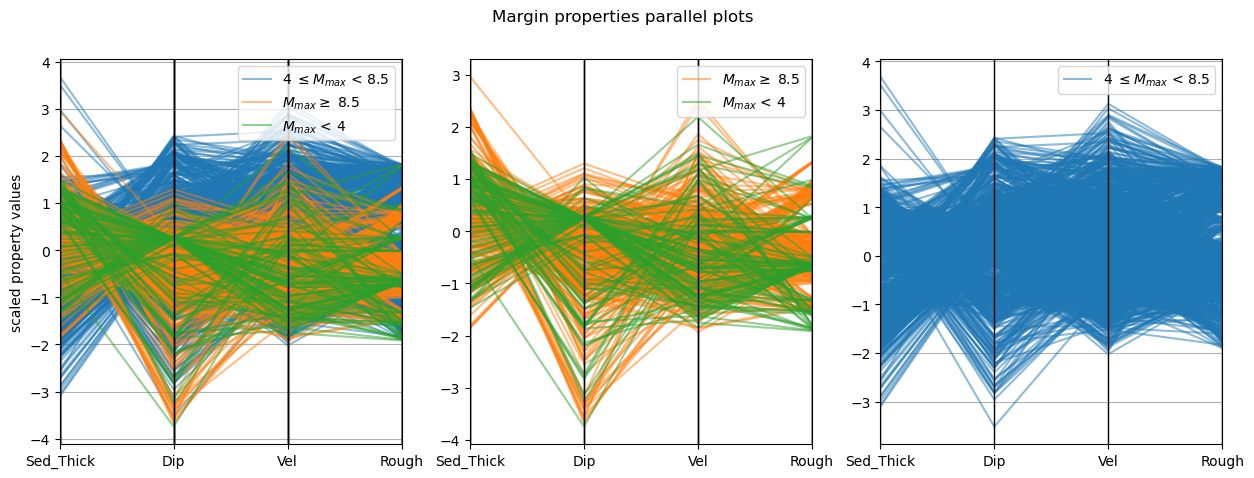

In [17]:
# prepare data for plotting
plotdata = pd.DataFrame(pca_preproc.fit_transform(linear_data), columns = ['Sed_Thick', 'Dip', 'Vel', 'Rough'])
plotdata = pd.concat([plotdata, linear_data['Max_mag']], axis = 1)

labels = ['$M_{max} \geq$ 8.5', '4 $ \leq M_{max}$ < 8.5', '$M_{max}$ < 4']
plotdata['label'] = [labels[0] if mag >= 8.5 else labels[1] if mag >=4 else labels[2] for mag in linear_data.Max_mag]
plotdata = plotdata.drop(columns = 'Max_mag')

# define figure and subplots, set title and y-axis label 
fig,ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Margin properties parallel plots')
ax[0].set_ylabel('scaled property values')

# subplot 0: all data
parallel_coordinates(plotdata[plotdata.label == labels[1]], 'label', color='tab:blue', alpha=.5, ax=ax[0])
parallel_coordinates(plotdata[plotdata.label == labels[0]], 'label', color='tab:orange', alpha=.5, ax=ax[0])
parallel_coordinates(plotdata[plotdata.label == labels[2]], 'label', color='tab:green', alpha=.5, ax=ax[0])

# subplot 1: only maximum magnitudes < 4 or >= 8.5
parallel_coordinates(plotdata[plotdata.label == labels[0]], 'label', color='tab:orange', alpha=.5, ax=ax[1])
parallel_coordinates(plotdata[plotdata.label == labels[2]], 'label', color='tab:green', alpha=.5, ax=ax[1])

# subplot 2: only maximum magnitudes between 4 and 8.5
parallel_coordinates(plotdata[plotdata.label == labels[1]], 'label', color='tab:blue', alpha=.5, ax=ax[2])